# 1 Data Preprocessing and Feature Engineering

In [150]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler 
from sklearn.exceptions import FitFailedWarning
import xgboost as xgb
from sklearn.svm import SVR


sns.set(font_scale=0.6)
warnings.filterwarnings('ignore', category=FitFailedWarning)

### Loading and understanding the data

In [2]:
# load data into df
path = 'data/Dataset-PT.csv'
df = pd.read_csv(path, header=1)
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1


### Data exploration and visualisation

##### Mean Arrival and Origin Delay

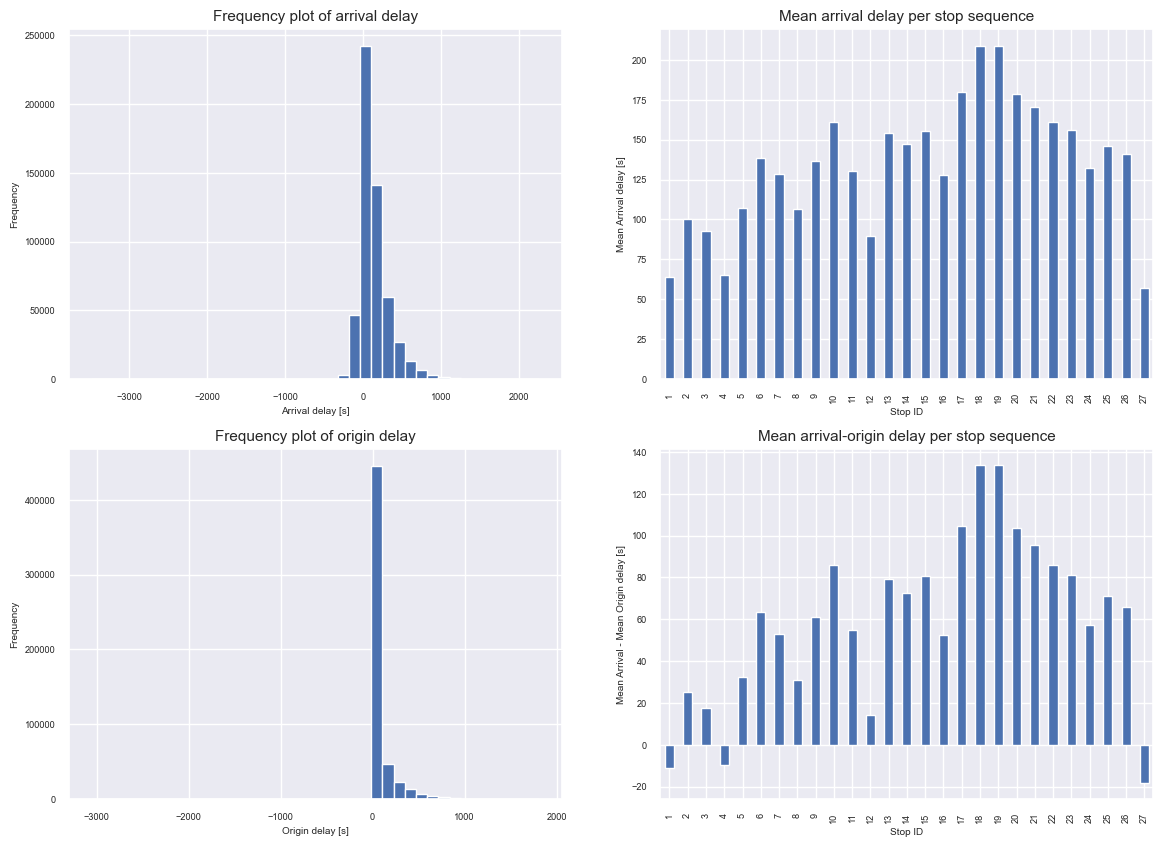

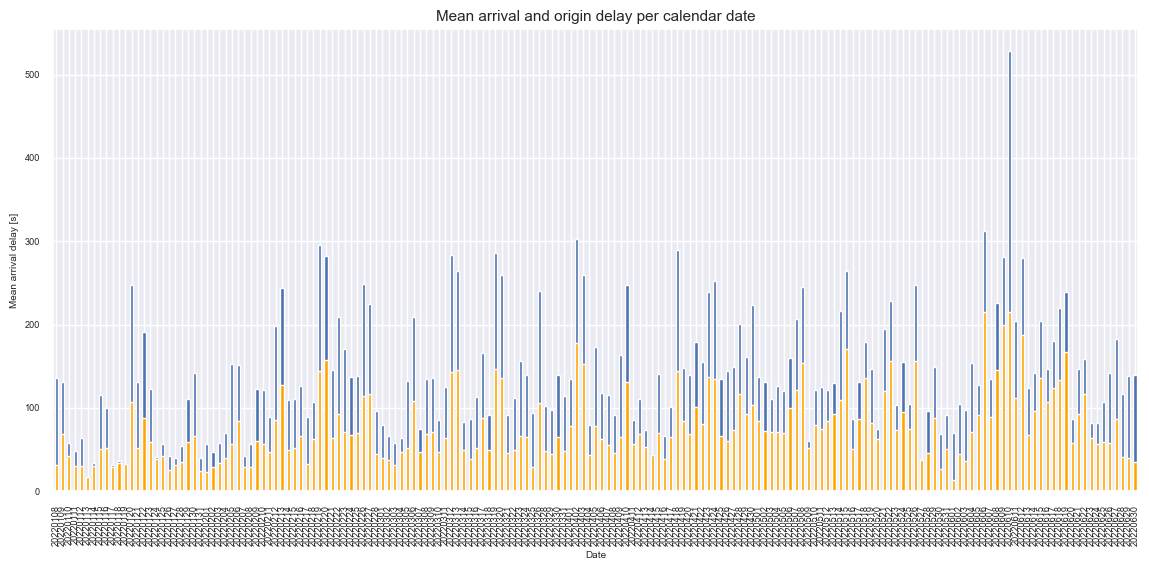

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ARRIVAL DELAY
# histogram
df['arrival_delay'].plot.hist(bins=40, ax=axes[0][0])
axes[0][0].set_title('Frequency plot of arrival delay', fontsize=11)
axes[0][0].set_xlabel('Arrival delay [s]')
axes[0][0].set_ylabel('Frequency')

# mean arrival delay per sequence stop
df.groupby('stop_sequence').arrival_delay.mean().plot.bar(ax=axes[0][1])
axes[0][1].set_title('Mean arrival delay per stop sequence', fontsize=11)
axes[0][1].set_xlabel('Stop ID')
axes[0][1].set_ylabel('Mean Arrival delay [s]')

# ORIGIN DELAY
# histogram
df['origin_delay'].plot.hist(bins=40, ax=axes[1][0])
axes[1][0].set_title('Frequency plot of origin delay', fontsize=11)
axes[1][0].set_xlabel('Origin delay [s]')
axes[1][0].set_ylabel('Frequency')

# mean arrival delay per sequence stop
df['arr_minus_orig'] = df['arrival_delay'] - df['origin_delay']
df.groupby('stop_sequence').arr_minus_orig.mean().plot.bar(ax=axes[1][1])
axes[1][1].set_title('Mean arrival-origin delay per stop sequence', fontsize=11)
axes[1][1].set_xlabel('Stop ID')
axes[1][1].set_ylabel('Mean Arrival - Mean Origin delay [s]')
plt.show()

# mean arrival delay per calendar date
df.groupby('Calendar_date').arrival_delay.mean().sort_index().plot.bar(figsize=(14, 6))
df.groupby('Calendar_date').origin_delay.mean().sort_index().plot.bar(color='orange')
plt.title('Mean arrival and origin delay per calendar date', fontsize=11)
plt.xlabel('Date')
plt.ylabel('Mean arrival delay [s]')
plt.show()

In [4]:
# why is arrival and origin delay so low sometimes? which records are these?
# bus trips where the arrival delay (- 5 min) and origin delay (-1min) are significatnly
df_negative = df[(df['arrival_delay'] < -300) & (df['origin_delay'] < -60)] # 16 trips
print('Unique Dates: ' + str(df_negative['Calendar_date'].unique()) + " (total: " + str(len(df_negative['Calendar_date'].unique())) + ")")
print('Unique Bus IDs: ' + str(df_negative['bus_id'].unique()) + " (total: " + str(len(df_negative['bus_id'].unique())) + ")")
print('Unique Dates: ' + str(df_negative['stop_sequence'].unique()) + " (total: " + str(len(df_negative['stop_sequence'].unique())) + ")" + ")")
print('Unique Dates: ' + str(df_negative['weather'].unique()) + " (total: " + str(len(df_negative['weather'].unique())) + ")")

pd.DataFrame(df[df['arrival_delay'] < -700].value_counts())

# potential explanations: extra buses when sudden increase in demand is expected, overtaking buses when high traffic

Unique Dates: [20220525 20220628 20220630] (total: 3)
Unique Bus IDs: [45533 44417 44418 45535 45532 45537 41725 45534 44414 41373 41361] (total: 11)
Unique Dates: [24 27  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 25 26] (total: 27))
Unique Dates: ['Normal'] (total: 1)


count
Calendar_date route_id bus_id stop_sequence arrival_delay dwell_time travel_time_for_previous_section scheduled_travel_time upstream_stop_delay origin_delay previous_bus_delay previous_trip_travel_time traffic_condition recurrent_delay weather temperature day_of_week time_of_day factor(weather)Light_Rain factor(weather)Light_Snow factor(weather)Normal factor(weather)Rain factor(weather)Snow factor(temperature)Cold factor(temperature)Extra_cold factor(temperature)Normal factor(day_of_week)weekday factor(day_of_week)weekend factor(time_of_day)Afternoon_peak factor(time_of_day)Morning_peak factor(time_of_day)Off-peak arr_minus_orig       
20220525      4        44417  1             -1397         0          0                                180                   -1372               -1372        -39                122                       130.666667        140.733840      Normal  Normal      weekday     MP          0                         0                         1                     0                   0                   0                       0                             1                         1                          0                          0                                 1                               0                           -25                 1
                       45537  17            -924          55         164                              93                    -1024               -973          60                69                        119.333333        78.553073       Normal  Normal      weekday     OP          0                         0                         1                     0                   0                   0                       0                             1                         1                          0                          0                                 0                               1                            49                 1
                       45533  25            -764          28         112                              69                    -766                -346         -18                34                        39.333333         47.021552       Normal  Normal      weekday     AP          0                         0                         1                     0                   0                   0                       0                             1                         1                          0                          1                                 0                               0                           -418                1
                              26            -788          0          43                               94                    -764                -346         -42                70                        65.000000         69.224138       Normal  Normal      weekday     AP          0                         0                         1                     0                   0                   0                       0                             1                         1                          0                          1                                 0                               0                           -442                1
                              27            -892          20         70                               174                   -788                -346         -159               44                        44.666667         51.905172       Normal  Normal      weekday     AP          0                         0                         1                     0                   0                   0                       0                             1                         1                          0                          1                                 0                               0                           -546                1
...                                                                                                                               

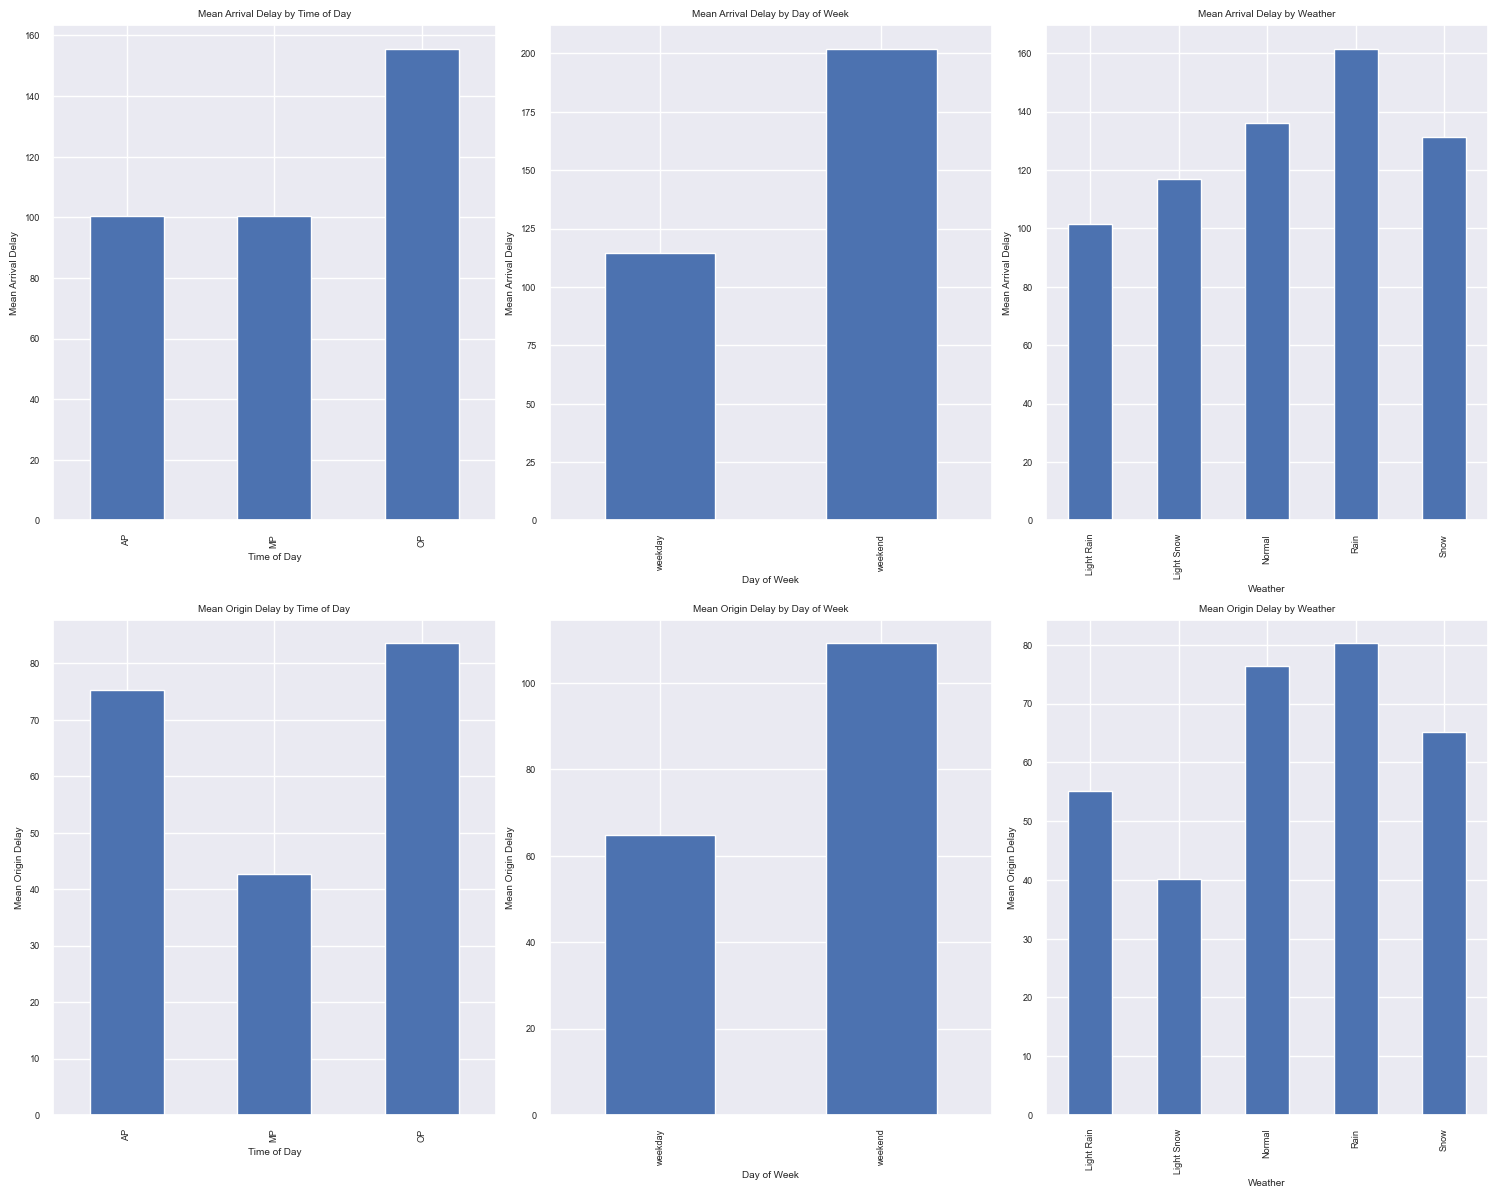

arrival_delay                                                      \
                    count        mean         std     min   25%    50%    75%   
time_of_day                                                                     
AP               113751.0  100.254890  186.904289 -1656.0 -12.0   54.0  166.0   
MP                89883.0  100.345238  177.431529 -3493.0  -2.0   69.0  172.0   
OP               341469.0  155.652042  197.356115 -1349.0  26.0  105.0  233.0   

                    origin_delay                                             \
                max        count       mean         std     min   25%   50%   
time_of_day                                                                   
AP           1605.0     113751.0  75.293615  134.009608 -1483.0  15.0  27.0   
MP           2210.0      89883.0  42.753079  106.512766 -3061.0  13.0  24.0   
OP           2257.0     341469.0  83.561556  138.522882 -1261.0  15.0  29.0   

                           
              75%     max  
time_of_day                
AP           66.0  1029.0  
MP           44.0  1812.0  
OP           81.0  1285.0

arrival_delay                                                      \
                    count        mean         std     min   25%    50%    75%   
day_of_week                                                                     
weekday          418149.0  114.589024  181.190084 -3493.0   2.0   74.0  185.0   
weekend          126954.0  202.108527  217.768790  -346.0  52.0  139.0  295.0   

                    origin_delay                                              \
                max        count        mean         std     min   25%   50%   
day_of_week                                                                    
weekday      2257.0     418149.0   64.753729  121.986719 -3061.0  14.0  26.0   
weekend      1456.0     126954.0  109.208635  161.676613  -467.0  16.0  35.0   

                            
               75%     max  
day_of_week                 
weekday       58.0  1812.0  
weekend      128.0  1203.0

arrival_delay                                                       \
                   count        mean         std     min   25%    50%     75%   
weather                                                                         
Light Rain       13338.0  101.520843  154.034340  -322.0   1.0   66.0  164.75   
Light Snow        9720.0  116.779733  144.641747  -364.0  17.0   83.0  190.00   
Normal          514971.0  136.034216  195.699613 -3493.0  11.0   89.0  210.00   
Rain              3375.0  161.584593  187.168419  -251.0  27.0  117.0  257.00   
Snow              3699.0  131.268992  174.475820  -242.0  13.0   82.0  196.00   

                   origin_delay                                              \
               max        count       mean         std     min    25%   50%   
weather                                                                       
Light Rain  1025.0      13338.0  55.208502   95.455980  -193.0  13.00  24.0   
Light Snow   778.0       9720.0  40.094444   74.447970  -313.0  11.75  22.0   
Normal      2257.0     514971.0  76.321449  135.302344 -3061.0  15.00  28.0   
Rain         810.0       3375.0  80.288000  141.552753    -7.0  14.00  26.0   
Snow         924.0       3699.0  65.094891  109.642918    -9.0  14.00  25.0   

                          
             75%     max  
weather                   
Light Rain  57.0   983.0  
Light Snow  44.0   637.0  
Normal      69.0  1812.0  
Rain        72.0   741.0  
Snow        53.0   600.0

In [5]:
# Plot mean arrival and origin delay per different categorical data, and calculate some statistics
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

variables = ['time_of_day', 'day_of_week', 'weather']
var_titles = ['Time of Day', 'Day of Week', 'Weather']
delay_titles = ['Arrival', 'Origin']

for i, var in enumerate(variables):
    for j, delay in enumerate(['arrival_delay', 'origin_delay']):
        df.groupby(var)[delay].mean().plot.bar(ax=axes[j, i])
        axes[j, i].set_title('Mean {} Delay by {}'.format(delay_titles[j], var_titles[i]))
        axes[j,i].set_xlabel(var_titles[i])
        axes[j,i].set_ylabel('Mean {} Delay'.format(delay_titles[j]))

plt.tight_layout()
plt.show()

display(df.groupby('time_of_day')[['arrival_delay', 'origin_delay']].describe())
display(df.groupby('day_of_week')[['arrival_delay', 'origin_delay']].describe())
display(df.groupby('weather')[['arrival_delay', 'origin_delay']].describe())

##### Trip Count

In [6]:
# Frequency plot for trips, by attribute
def plot_trips_by_attr(df, attr, title, sort):
    if sort:
        df[attr].value_counts().sort_index().plot.bar(figsize=(14, 6))
    else:
        df[attr].value_counts().plot.bar(figsize=(14, 6))
    plt.title(title, fontsize=12)
    plt.xlabel(attr, fontsize=11)
    plt.ylabel('count', fontsize=11)
    # divide y ticks by 27 to display number of trips
    plt.yticks(ticks=plt.gca().get_yticks(), labels=[int(ytick / 27) for ytick in plt.gca().get_yticks()])
    plt.show()

Average number of trips per day: 116.7


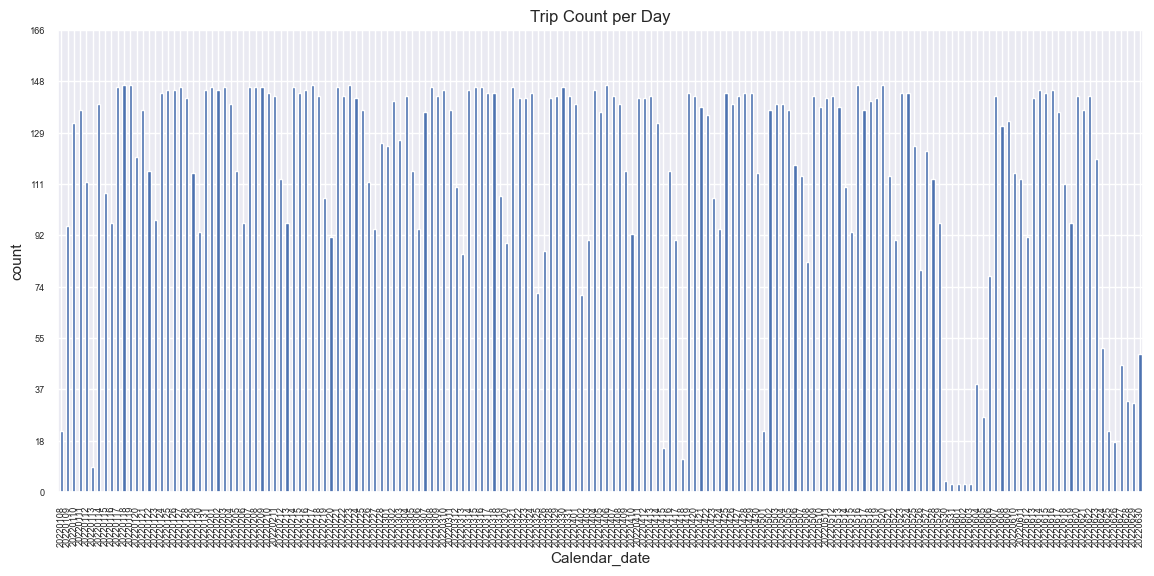

Number of unique buses: 152
Average number of trips per bus: 132.82
Number of buses with <=2 trips: 44


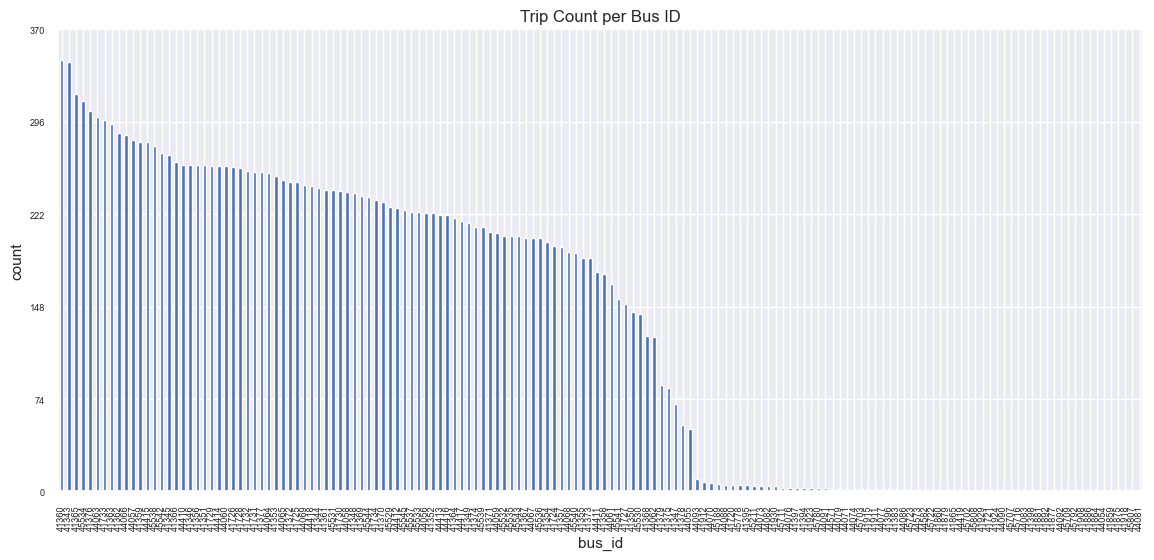

In [7]:
# See how many trips there are per day throughout they year, and how often the same buses are used.

print('Average number of trips per day: ' + str(np.mean(df['Calendar_date'].value_counts().values / 27).round(2)))
plot_trips_by_attr(df, 'Calendar_date', 'Trip Count per Day', True)

print('Number of unique buses: ' + str(len(df['bus_id'].unique())))
print('Average number of trips per bus: ' + str(np.mean(df['bus_id'].value_counts().values / 27).round(2)))
print('Number of buses with <=2 trips: ' + str(len(np.where(df['bus_id'].value_counts().values / 27<=2)[0])))

plot_trips_by_attr(df, 'bus_id', 'Trip Count per Bus ID', False)

Mean origin delay (stop 0):  75.11


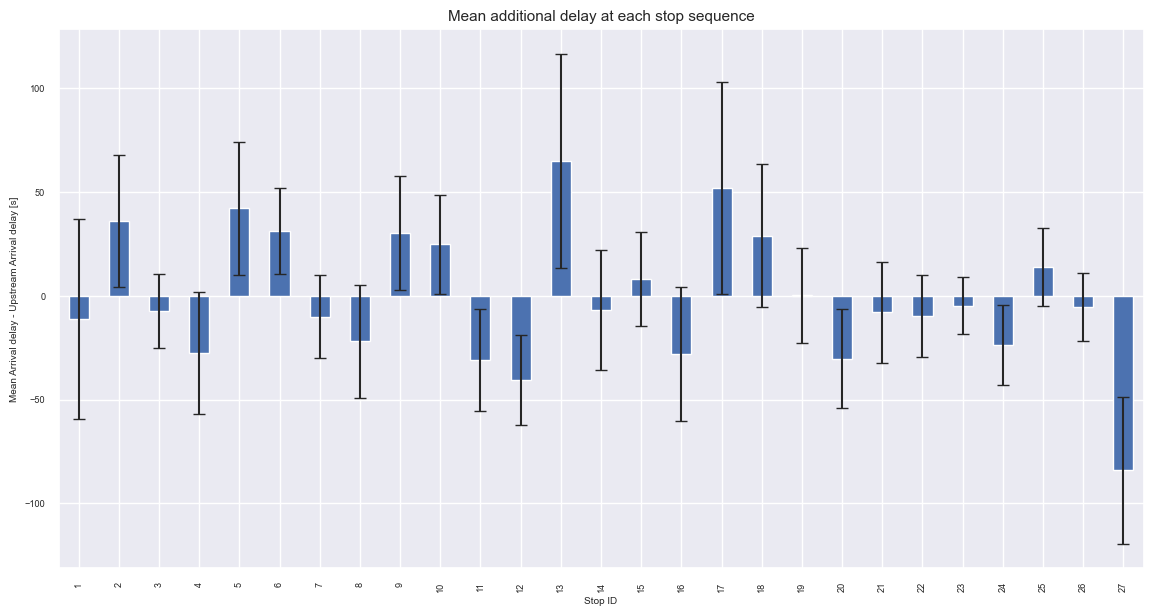

In [8]:
# Contribution to delay at each stop
print('Mean origin delay (stop 0): ', round(np.mean(df.origin_delay),2))
df['delay_diff'] = df['arrival_delay'] - df['upstream_stop_delay']

df.groupby('stop_sequence').delay_diff.mean().plot.bar(yerr=df.groupby('stop_sequence').delay_diff.std(), figsize=(14, 7), capsize=4)  # capsize controls the size of error bar caps
plt.title('Mean additional delay at each stop sequence', fontsize=11)
plt.xlabel('Stop ID')
plt.ylabel('Mean Arrival delay - Upstream Arrival delay [s]')

# Show the plot
plt.show()

### Correlations of different factors

In [9]:
# create further columns, with combined variables
df['upstream_delay_incl_dwell'] = df['upstream_stop_delay'] + df['dwell_time']
df['dwell_incl_origin'] = np.abs(df['previous_bus_delay'] - df['origin_delay'])

,arrival_delay
arrival_delay,1.000000
upstream_delay_incl_dwell,0.986756
upstream_stop_delay,0.975019
arr_minus_orig,0.725114
origin_delay,0.716324
dwell_incl_origin,0.309329
previous_bus_delay,0.265434
delay_diff,0.194518
factor(day_of_week)weekend,0.190783
factor(time_of_day)Off-peak,0.138109


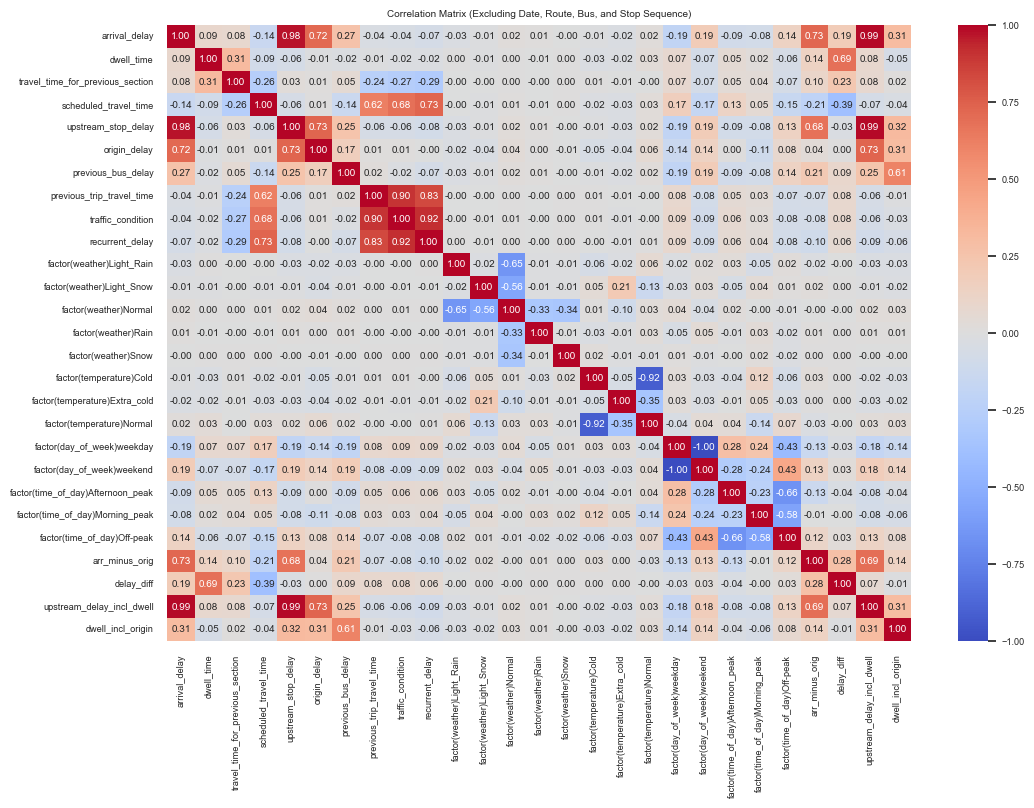

In [10]:
# create correlation matrix of numeric attributes
df_numeric = df.drop(columns=['Calendar_date', 'route_id', 'bus_id', 'stop_sequence'], errors='ignore')
corr_matrix = df_numeric.select_dtypes(include='number').corr()

# variables where correlation is bigger than 0.1
display(pd.DataFrame(corr_matrix[abs(corr_matrix) > 0.1]['arrival_delay'].dropna().sort_values(ascending=False)))

# create heatmap of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix (Excluding Date, Route, Bus, and Stop Sequence)')
plt.show()

In [132]:
X = df[['scheduled_travel_time','previous_bus_delay','previous_trip_travel_time', 
'recurrent_delay', 'upstream_delay_incl_dwell']]
y = df['arrival_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

12.672953014210904 403.59633921541064 0.9892062351301685


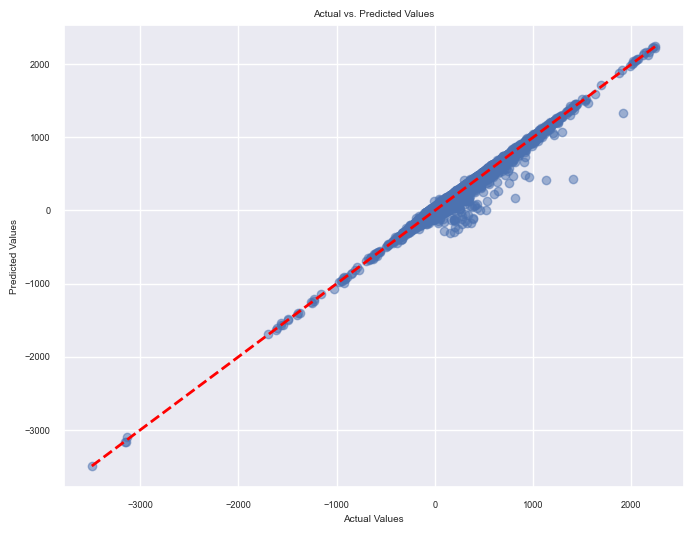

In [133]:
# Linear regression

model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_pred_linear = model_linear.predict(X_test)

mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(mae_linear, mse_linear, r2_linear)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
plt.show()

In [131]:
# Decision tree
# XGBoost
# SVM
# Neural Net

12.67295301421091 403.5963392154106 0.9892062351301685


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/marinawiemers/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [  -633.00222786             nan  -4231.64102239  -1121.03316612
 -30696.2541863              nan             nan             nan
 -30696.25728295 -19044.64690047  -3951.38899418   -625.08161539
  -4680.39489485 -14618.73141338   -928.14187185  -2931.41905412
 -35161.87357924   -631.68296828   -482.20068282  -9453.98627664
             nan             nan  -6533.95904216             nan
             nan -30696.2541863  -19461.11394381  -3951.38899418
   -928.14187185             nan   -916.08935097   -624.99334644
   -849.53494639             nan  -9453.98627664  -1837.42311885
  -1328.98249127  -2601.5534555  -19461.11394381 -28592.08856305
  -2715.81166643  -5022.54187344             nan             nan
             nan   -627.37888568 -30696.2541863              nan
 -23103.75309662   -849.53501541   -928.32396694 -14618.7314

Best parameters from RandomizedSearchCV:  {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 24, 'criterion': 'friedman_mse'}
RandomizedSearchCV RMSE: 23.0094
DecisionTreeRegressor MAE: 14.4227
DecisionTreeRegressor MSE: 498.3534
DecisionTreeRegressor RMSE: 22.3238
DecisionTreeRegressor R2: 0.9867


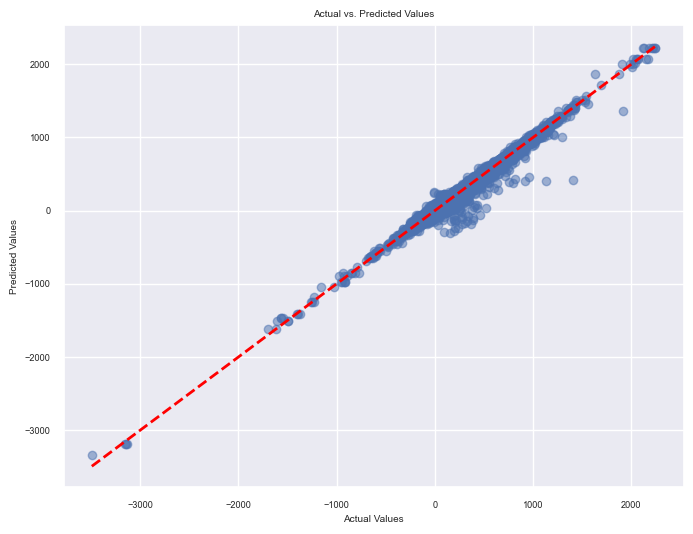

In [144]:
# Decision tree
model = DecisionTreeRegressor(random_state=42)

# hyper parameters to test randomly using RandomizedSearch
params_dt = {
    'criterion': ["squared_error", "friedman_mse"],
    'splitter': ['best', 'random'],
    'max_depth': [2, 4, 8, 24, 48, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    
}

random_search_dt = RandomizedSearchCV(
    model, 
    param_distributions=params_dt,
    n_iter=100, 
    scoring='neg_mean_squared_error',
    cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search_dt.fit(X_train, y_train)

print("Best parameters from RandomizedSearchCV: ", random_search_dt.best_params_)
best_model_random_dt = random_search_dt.best_estimator_

y_pred_random_dt = best_model_random_dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_random_dt)
mse_dt = mean_squared_error(y_test, y_pred_random_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_random_dt)

print(f'DecisionTreeRegressor MAE: {mae_dt:.4f}')
print(f'DecisionTreeRegressor MSE: {mse_dt:.4f}')
print(f'DecisionTreeRegressor RMSE: {rmse_dt:.4f}')
print(f'DecisionTreeRegressor R2: {r2_dt:.4f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_random_dt, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
plt.show()

In [138]:
mae_grid = mean_absolute_error(y_test, y_pred_grid)
mse_grid = mean_squared_error(y_test, y_pred_grid)
r2_grid = r2_score(y_test, y_pred_grid)
print(mae_grid, mse_grid, r2_grid)


23.17690660570619 1431.1610253837098 0.9617250849477752


In [139]:
mae_grid = mean_absolute_error(y_test, y_pred_random)
mse_grid = mean_squared_error(y_test, y_pred_random)
r2_grid = r2_score(y_test, y_pred_random)
print(mae_grid, mse_grid, r2_grid)

15.257615769625016 529.4332071815813 0.9858408588053402


Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best parameters from RandomizedSearchCV (XGBoost):  {'subsample': 0.8, 'min_child_weight': 0, 'max_depth': 4, 'gamma': 8, 'eta': 0.1}
XGBoost MAE: 14.4083
XGBoost MSE: 1208.8017
XGBoost RMSE: 34.7678
XGBoost R2: 0.9677


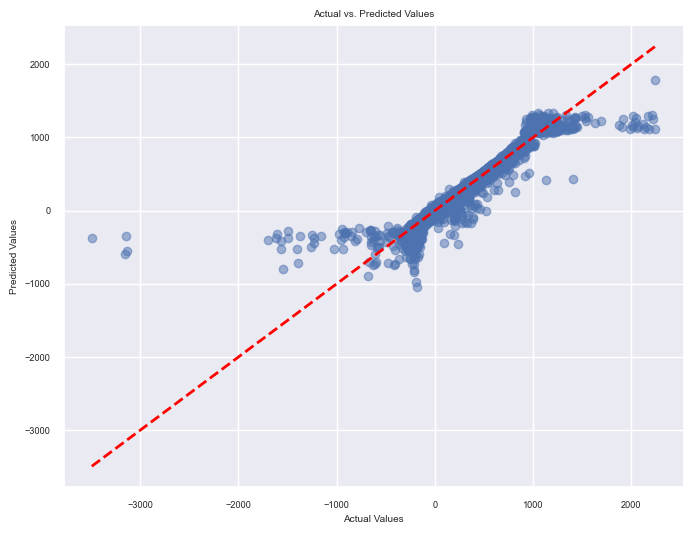

In [149]:
# XGBoost
model_xgb = xgb.XGBRegressor(random_state=42)

params_xgb = {
  'eta': [0.075, 0.1, 0.3], 
  'gamma': [0, 2, 4, 8, 16], 
  'max_depth': [2, 4, 6, 8, 24],
  'min_child_weight': [0, 1, 2],
  'subsample': [0.2, 0.75, 0.8, 1],
}


random_search_xgb = RandomizedSearchCV(
    model_xgb, 
    param_distributions=params_xgb,
    n_iter=70, 
    scoring='neg_mean_squared_error',
    cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

print("Best parameters from RandomizedSearchCV (XGBoost): ", random_search_xgb.best_params_)
best_model_random_xgb = random_search_xgb.best_estimator_
y_pred_random_xgb = best_model_random_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_random_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_random_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_random_xgb)

print(f'XGBoost MAE: {mae_xgb:.4f}')
print(f'XGBoost MSE: {mse_xgb:.4f}')
print(f'XGBoost RMSE: {rmse_xgb:.4f}')
print(f'XGBoost R2: {r2_xgb:.4f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_random_xgb, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
plt.show()

In [ ]:
# Support Vector Regression
model_svm = SVR()

params_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'],
    'C': [0.2, 0.5, 1.0, 2.0]
}


random_search_svm = RandomizedSearchCV(
    model_svm, 
    param_distributions=params_svm,
    n_iter=1, 
    scoring='neg_mean_squared_error',
    cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search_svm.fit(X_train, y_train)

print("Best parameters from RandomizedSearchCV (SVR): ", random_search_svm.best_params_)
best_model_random_svm = random_search_svm.best_estimator_
y_pred_random_svm = best_model_random_svm.predict(X_test)

mae_svm = mean_absolute_error(y_test, y_pred_random_svm)
mse_svm = mean_squared_error(y_test, y_pred_random_svm)
rmse_svm = np.sqrt(mse_svm)
r2_svm = r2_score(y_test, y_pred_random_svm)

print(f'SVR MAE: {mae_svm:.4f}')
print(f'SVR MSE: {mse_svm:.4f}')
print(f'SVR RMSE: {rmse_svm:.4f}')
print(f'SVR R2: {r2_svm:.4f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_random_svm, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
